# 4M: Massively Multimodal Masked Modeling

*David Mizrahi\*, Roman Bachmann\*, Oguzhan Fatih Kar, Teresa Yeo, Mingfei Gao, Afshin Dehghan, Amir Zamir*

[`Website`](https://4m.epfl.ch) | [`Paper`](https://arxiv.org/abs/2312.06647) | [`GitHub`](https://github.com/apple/ml-4m)

4M is a framework for training "any-to-any" foundation models, using tokenization and masking to scale to many diverse modalities. 
Models trained using 4M can perform a wide range of vision tasks, transfer well to unseen tasks and modalities, and are flexible and steerable multimodal generative models.

This notebook contains examples for 4M inference, specifically performing conditional image generation and common vision tasks (i.e. RGB-to-All).

In [1]:
# Switch path to root of project
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import center_crop
from tokenizers import Tokenizer
import matplotlib.pyplot as plt

from fourm.models.fm import FM
from fourm.vq.vqvae import VQVAE, DiVAE
from fourm.models.generate import GenerationSampler, build_chained_generation_schedules, init_empty_target_modality, init_full_input_modality, custom_text
from fourm.data.modality_transforms import RGBTransform
from fourm.data.modality_info import MODALITY_INFO
from fourm.utils.plotting_utils import decode_dict, visualize_bboxes, plot_text_in_square

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

/cluster/home/kevidu/micromamba/envs/fourm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


xFormers not available
xFormers not available
No module named 'detectron2'
Detectron2 can be used for semseg visualizations. Please install detectron2 to use this feature, or plotting will fall back to matplotlib.


In [3]:
device

'cuda'

### Load tokenizers

To encode modalities into discrete tokens, and in turn decode the tokens that 4M predicts, we use modality-specific tokenizers. We can easily load them from [Hugging Face hub](https://huggingface.co/EPFL-VILAB) with the below lines.

The tokenizer checkpoint names are formated as: `f'4M_tokenizers_{modality}_{vocab_size}_{min_res}-{max–res}'`.
All tokenizers here are trained to work on resolutions between 224 and 448, in steps of 32.

In [4]:
text_tok = Tokenizer.from_file('./fourm/utils/tokenizer/trained/text_tokenizer_4m_wordpiece_30k.json')

toks = {
    'tok_rgb': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_rgb_16k_224-448').eval().to(device),
    'tok_depth': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_depth_8k_224-448').eval().to(device),
    'tok_normal': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_normal_8k_224-448').eval().to(device),
    'tok_semseg': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_semseg_4k_224-448').eval().to(device),
    'tok_clip': VQVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_CLIP-B16_8k_224-448').eval().to(device),
}

### Load 4M and 4M super-resolution models

Let's load a 4M-7 XL model that was trained on 7 modalities, including RGB, depth, surface normals, semantic segmentation, CLIP-B/16 features, captions, and bounding boxes. It can take any combination of those modalities as input, and can predict all of them. We wrap the model in a `GenerationSampler` which provides inference utilities.

Please see the `README.md` for all available 4M and tokenizer models.

In [5]:
fm = FM.from_pretrained('EPFL-VILAB/4M-7_XL_CC12M').eval().to(device)
sampler = GenerationSampler(fm)

The above base model operates on 224x224 images, and the tokenizers have patch size 16x16. That means each image-like modality consists of 196 discrete tokens. Compressing an image into 224x224 tokens removes a lot of high frequency details. Thus, we also trained a super-resolution version of 4M, where the model can generate the image-like modalities at a resolution of 448x448 (784 tokens) conditioned on the low-res 224x224 versions.

In [6]:
fm_sr = FM.from_pretrained('EPFL-VILAB/4M-7-SR_L_CC12M').eval().to(device)
sampler_sr = GenerationSampler(fm_sr)

### RGB → All

Given an RGB input, predict all other modalities. Inference/generation is done by providing a _generation schedule_ to the `GenerationSampler`. 
A _generation schedule_ specifies the order of modalities to generate, and for each it contains the generation parameters like number of steps or temperature.
We provide a convenience function `build_chained_generation_schedules` that allows for building arbitrary chained generation schedules.
We call it chained generation, since every newly generated output is looped back into the input and serves as conditioning for subsequently generated modalities.
This enables generating multiple modalities that are all consistent with each other, which is mostly important when the conditioning is underspecified.
Please see the paper for more details on chained generation.

The `build_chained_generation_schedules` function takes several inputs. 
Please see the generation README in `README_GENERATION.md` for detailed information on each of them, and tips on how to set them.
In the following, we give an RGB image as input (pixels not tokens), and predict all other modalities from it.

In [7]:
cond_domains = ['rgb@224']
target_domains = ['tok_clip@224', 'tok_depth@224', 'tok_normal@224', 'tok_semseg@224', 'caption', 'det']
tokens_per_target = [196, 196, 196, 196, 256, 256]
autoregression_schemes = ['roar', 'roar', 'roar', 'roar', 'autoregressive', 'autoregressive']
decoding_steps = [1, 1, 1, 1, None, None]
token_decoding_schedules = ['linear', 'linear', 'linear', 'linear', None, None]
temps = [0.01, 0.01, 0.01, 0.01, 0.3, 0.7]
temp_schedules = ['constant'] * len(target_domains)
cfg_scales = [2.0] * len(target_domains)
cfg_schedules = ['constant'] * len(target_domains)
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  397k  100  397k    0     0   571k      0 --:--:-- --:--:-- --:--:--  572k


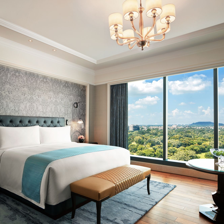

In [8]:
# Download image from the specified URL and preprocess it
image_url = 'https://i.imgur.com/AptRF3J.jpg'
!curl $image_url --output input.jpg

rgb_transform = RGBTransform(imagenet_default_mean_and_std=True)
img_pil = rgb_transform.load('./input.jpg')
img_pil = rgb_transform.preprocess(img_pil)
img_pil = center_crop(img_pil, (min(img_pil.size), min(img_pil.size))).resize((224,224))
img = rgb_transform.postprocess(img_pil).unsqueeze(0).to(device)
img_pil

4M operates on a dictionary of the input and target modalities that for each modality hold the actual token values (or pixels for RGB), input and target masks that specify which of the tokens are used as input and which need to be predicted, as well as attention masks for the decoder. Wherever the `input_mask` is `False`, the corresponding entries are used as input, wherever it is `True` the tokens are ignored. Wherever the `target_mask` is `False`, the corresponding entries are predicted as targets, wherever it is `True` nothing is predicted. 

The dictionary is formatted in the following way, with B = batch size, and N = sequence length of each respective modality:

```python
sample_dict = {
    modality_id: {
        'tensor': ..., # Contains the discrete tokens ()
        'input_mask': ..., # Boolean Tensor of shape B x N, where False = used as input, and True = ignored.
        'target_mask': ..., # Boolean Tensor of shape B x N, where False = predicted as target, and True = ignored.
        'decoder_attention_mask': ..., # Tensor containing the decoder attention pattern. Not used during inference.
    },
    ...
}
```

In [9]:
batched_sample = {
    'rgb@224': {
        'tensor': img, # Batched tensor
        'input_mask': torch.zeros(1, 196, dtype=torch.bool, device=device), # False = used as input, True = ignored
        'target_mask': torch.ones(1, 196, dtype=torch.bool, device=device), # False = predicted as target, True = ignored
    }
}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)
    
# Initialize input modalities
for cond_mod in cond_domains:
    batched_sample = init_full_input_modality(batched_sample, MODALITY_INFO, cond_mod, device, eos_id=text_tok.token_to_id("[EOS]"))

Now we are ready to perform the generation. The `GenerationSampler` has a `.generate` function that performs the chained generation on a given sample dictionary, following the previously specified generation schedule.
It outputs a dictionary that is formatted in the same manner as the sample dictionary, but contains also the predicted tokens. You can change the seed to get different outputs, or set it to None to randomly sample.

4M / the sampler outputs discrete tokens, and we still need to decode them to images, feature maps, text, etc using the modality-specific tokenizers. 
For that, we provide the `decode_dict` function that takes as input the sample dictionary and the tokenizers, and returns plottable representations of each modality.
Some modalities like RGB, depth and normals use a diffusion model as the tokenizer decoder. You can specify the number of DDIM steps for decoding with `decoding_steps`.

In [10]:
out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=False, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

Let's plot the RGB input and all predicted outputs!

NB: To enable plotting of semantic segmentation maps with labels, please install detectron2. The plotting function will automatically switch to it, or fall back to matplotlib otherwise.

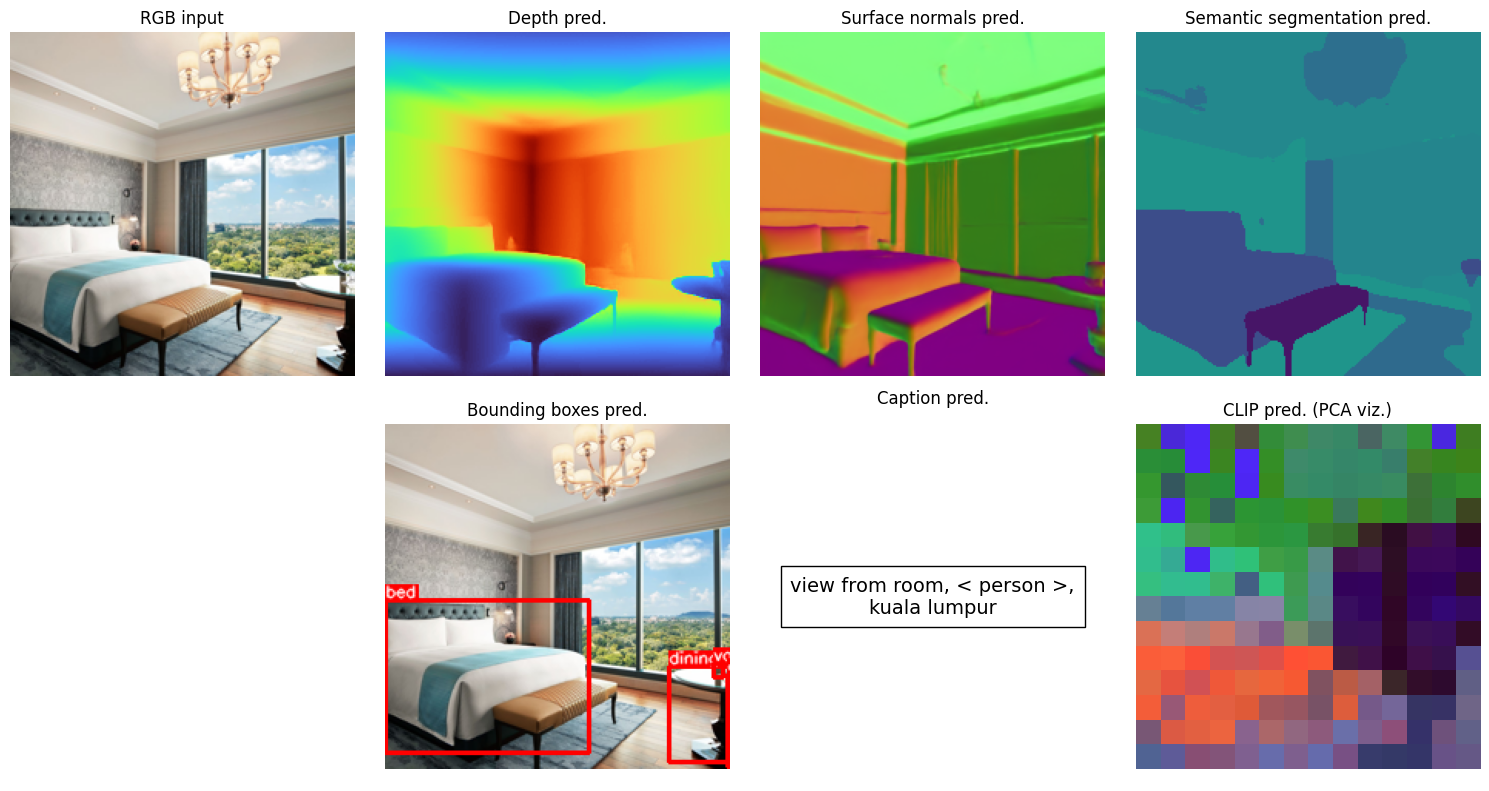

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8), facecolor=(1, 1, 1))

ax[0,0].imshow(img_pil)
ax[0,0].set_title('RGB input')

ax[0,1].imshow(dec_dict['tok_depth@224'])
ax[0,1].set_title('Depth pred.')

ax[0,2].imshow(dec_dict['tok_normal@224'])
ax[0,2].set_title('Surface normals pred.')

ax[0,3].imshow(dec_dict['tok_semseg@224'])
ax[0,3].set_title('Semantic segmentation pred.')

ax[1,1].imshow(visualize_bboxes(np.array(img_pil), dec_dict['det'][0],))
ax[1,1].set_title('Bounding boxes pred.')

plot_text_in_square(ax[1,2], dec_dict['caption'][0], wrap_width=32)
ax[1,2].set_title('Caption pred.')

ax[1,3].imshow(dec_dict['tok_clip@224'])
ax[1,3].set_title('CLIP pred. (PCA viz.)')

for axis in ax.flatten():
    axis.set_axis_off()

plt.tight_layout()
plt.show()

### Caption + bounding boxes → All

Inference from RGB images to the other spatial tasks can be performed well in one shot, but for generative tasks like caption-to-image we need to perform inference autoregressively.
Since 4M can perform chained generation, we can break down the generation process into a schedule of first generating intermediate modalities before generating the ones we care about most.
For example, we found that for text-to-image generation, generating CLIP features before RGB can improve generation fidelity.

Here, we generate all modalities by conditioning on captions and bounding boxes.

In [12]:
cond_domains = ['caption', 'det']
target_domains = ['tok_clip@224', 'tok_depth@224', 'tok_normal@224', 'tok_semseg@224', 'tok_rgb@224']
tokens_per_target = [196, 196, 196, 196, 196]
autoregression_schemes = ['roar', 'roar', 'roar', 'roar', 'roar']
decoding_steps = [50, 8, 8, 8, 25]
token_decoding_schedules = ['linear', 'linear', 'linear', 'linear', 'linear']
temps = [5.0, 3.0, 3.0, 3.0, 3.0]
temp_schedules = ['onex:0.5:0.5', 'onex:0.5:0.5', 'onex:0.5:0.5', 'onex:0.5:0.5', 'onex:0.5:0.5']
cfg_scales = [3.0, 2.0, 2.0, 2.0, 2.0]
cfg_schedules = ['constant', 'constant', 'constant', 'constant', 'constant']
cfg_grow_conditioning = True
top_p, top_k = 0.8, 0.0

schedule = build_chained_generation_schedules(
    cond_domains=cond_domains, target_domains=target_domains, tokens_per_target=tokens_per_target, autoregression_schemes=autoregression_schemes, 
    decoding_steps=decoding_steps, token_decoding_schedules=token_decoding_schedules, temps=temps, temp_schedules=temp_schedules,
    cfg_scales=cfg_scales, cfg_schedules=cfg_schedules, cfg_grow_conditioning=cfg_grow_conditioning, 
)

4M was trained with span masking, where sentinel tokens are specified by `[S_1]`, `[S_2]`, etc.
We can place them in caption and bounding box inputs to indicate to the model that there _could_ be something else there that was masked out, i.e. indicating that the input is not fully specified.

Bounding box coordinates are specified by 4000 special tokens, `xmin=...`, `ymin=...`, `xmax=...`, `ymax=...`, with each ranging from 0 to 999. 
See below for an example.

In [34]:
caption = 'a nice restaurant in santorini at sunset [S_1]'
bboxes = '[S_1] xmin=0 ymin=250 xmax=420 ymax=999 potted plant ' \
         'xmin=400 ymin=750 xmax=950 ymax=999 dining table ' \
         'xmin=350 ymin=250 xmax=700 ymax=350 boat ' \
         'xmin=700 ymin=720 xmax=740 ymax=850 bottle [S_2]'
# NOTES(kevin): maybe the [S_1] and [S_2] here indicate that the model is allowed to generate more than just the listed bounding boxes?

batched_sample = {}

# Initialize target modalities
for target_mod, ntoks in zip(target_domains, tokens_per_target):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)
    
# batched_sample = custom_text(
#     batched_sample, input_text=caption, eos_token='[EOS]', 
#     key='caption', device=device, text_tokenizer=text_tok
# )
# batched_sample = custom_text(
#     batched_sample, input_text=bboxes, eos_token='[EOS]', 
#     key='det', device=device, text_tokenizer=text_tok
# )
# NOTES(kevin): order here doesn't matter, because the custom_text just updates a dict for each given key
batched_sample = custom_text(
    batched_sample, input_text=bboxes, eos_token='[EOS]', 
    key='det', device=device, text_tokenizer=text_tok
)
batched_sample = custom_text(
    batched_sample, input_text=caption, eos_token='[EOS]', 
    key='caption', device=device, text_tokenizer=text_tok
)

In [35]:
out_dict = sampler.generate(
    batched_sample, schedule, text_tokenizer=text_tok, 
    verbose=False, seed=0,
    top_p=top_p, top_k=top_k,
)
dec_dict = decode_dict(
    out_dict, toks, text_tok, 
    image_size=224, patch_size=16,
    decoding_steps=50
)

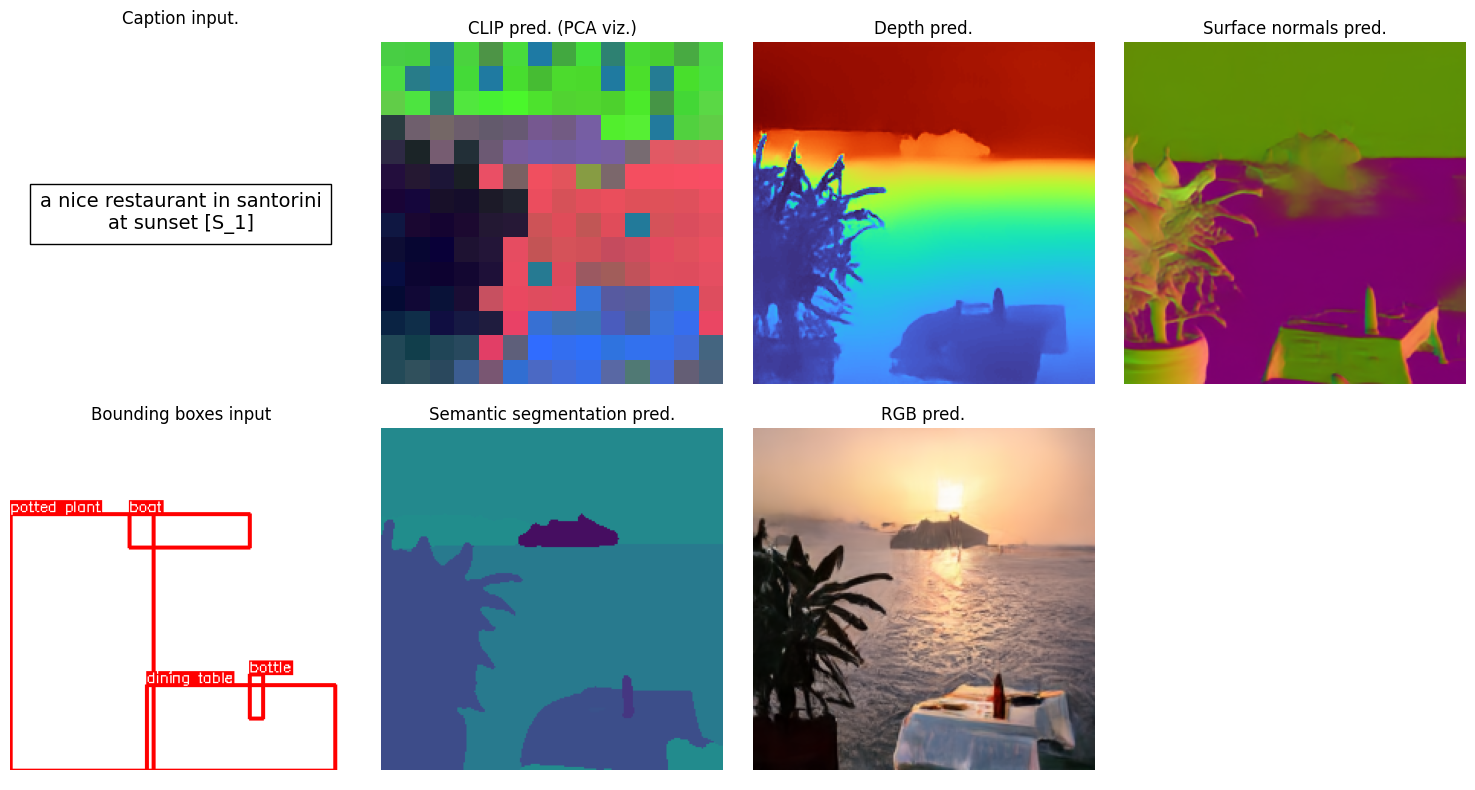

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8), facecolor=(1, 1, 1))

plot_text_in_square(ax[0,0], caption, wrap_width=32)
ax[0,0].set_title('Caption input.')

ax[1,0].imshow(visualize_bboxes(None, dec_dict['det'][0].replace('[PAD] ', '')))
ax[1,0].set_title('Bounding boxes input')

ax[0,1].imshow(dec_dict['tok_clip@224'])
ax[0,1].set_title('CLIP pred. (PCA viz.)')

ax[0,2].imshow(dec_dict['tok_depth@224'])
ax[0,2].set_title('Depth pred.')

ax[0,3].imshow(dec_dict['tok_normal@224'])
ax[0,3].set_title('Surface normals pred.')

ax[1,1].imshow(dec_dict['tok_semseg@224'])
ax[1,1].set_title('Semantic segmentation pred.')

ax[1,2].imshow(dec_dict['tok_rgb@224'])
ax[1,2].set_title('RGB pred.')

for axis in ax.flatten():
    axis.set_axis_off()

plt.tight_layout()
plt.show()

### Super-resolution

Now, let's super-resolve the above outputs in token space. We found that we can significantly lower the number of decoding steps for this.

In [30]:
cond_domains_sr = ['caption', 'det', 'tok_clip@224', 'tok_depth@224', 'tok_normal@224', 'tok_semseg@224', 'tok_rgb@224']
target_domains_sr = ['tok_clip@448', 'tok_depth@448', 'tok_normal@448', 'tok_semseg@448', 'tok_rgb@448']
tokens_per_target_sr = [784, 784, 784, 784, 784]
autoregression_schemes_sr = ['maskgit', 'maskgit', 'maskgit', 'maskgit', 'maskgit']
decoding_steps_sr = [8, 8, 8, 8, 8]
token_decoding_schedules_sr = ['cosine', 'cosine', 'cosine', 'cosine', 'cosine']
temps_sr = [1.0, 1.0, 1.0, 1.0, 1.0]
temp_schedules_sr = ['constant', 'constant', 'constant', 'constant', 'constant']
cfg_scales_sr = [2.0, 2.0, 2.0, 2.0, 2.0]
cfg_schedules_sr = ['constant', 'constant', 'constant', 'constant', 'constant']
cfg_grow_conditioning_sr = True
top_p_sr, top_k_sr = 0.0, 0.0

schedule_sr = build_chained_generation_schedules(
    cond_domains=cond_domains_sr, target_domains=target_domains_sr, tokens_per_target=tokens_per_target_sr, autoregression_schemes=autoregression_schemes_sr, 
    decoding_steps=decoding_steps_sr, token_decoding_schedules=token_decoding_schedules_sr, temps=temps_sr, temp_schedules=temp_schedules_sr,
    cfg_scales=cfg_scales_sr, cfg_schedules=cfg_schedules_sr, cfg_grow_conditioning=cfg_grow_conditioning_sr, 
)

In [31]:
# Initialize input modalities
for cond_mod in cond_domains_sr:
    batched_sample = init_full_input_modality(out_dict, MODALITY_INFO, cond_mod, device, eos_id=text_tok.token_to_id("[EOS]"))

# Initialize target modalities
for target_mod, ntoks in zip(target_domains_sr, tokens_per_target_sr):
    batched_sample = init_empty_target_modality(batched_sample, MODALITY_INFO, target_mod, 1, ntoks, device)

In [32]:
out_dict_sr = sampler_sr.generate(
    batched_sample, schedule_sr, text_tokenizer=text_tok, 
    verbose=False, seed=1,
    top_p=top_p, top_k=top_k,
)
dec_dict_sr = decode_dict(
    out_dict_sr, toks, text_tok, 
    image_size=448, patch_size=16,
    decoding_steps=50
)

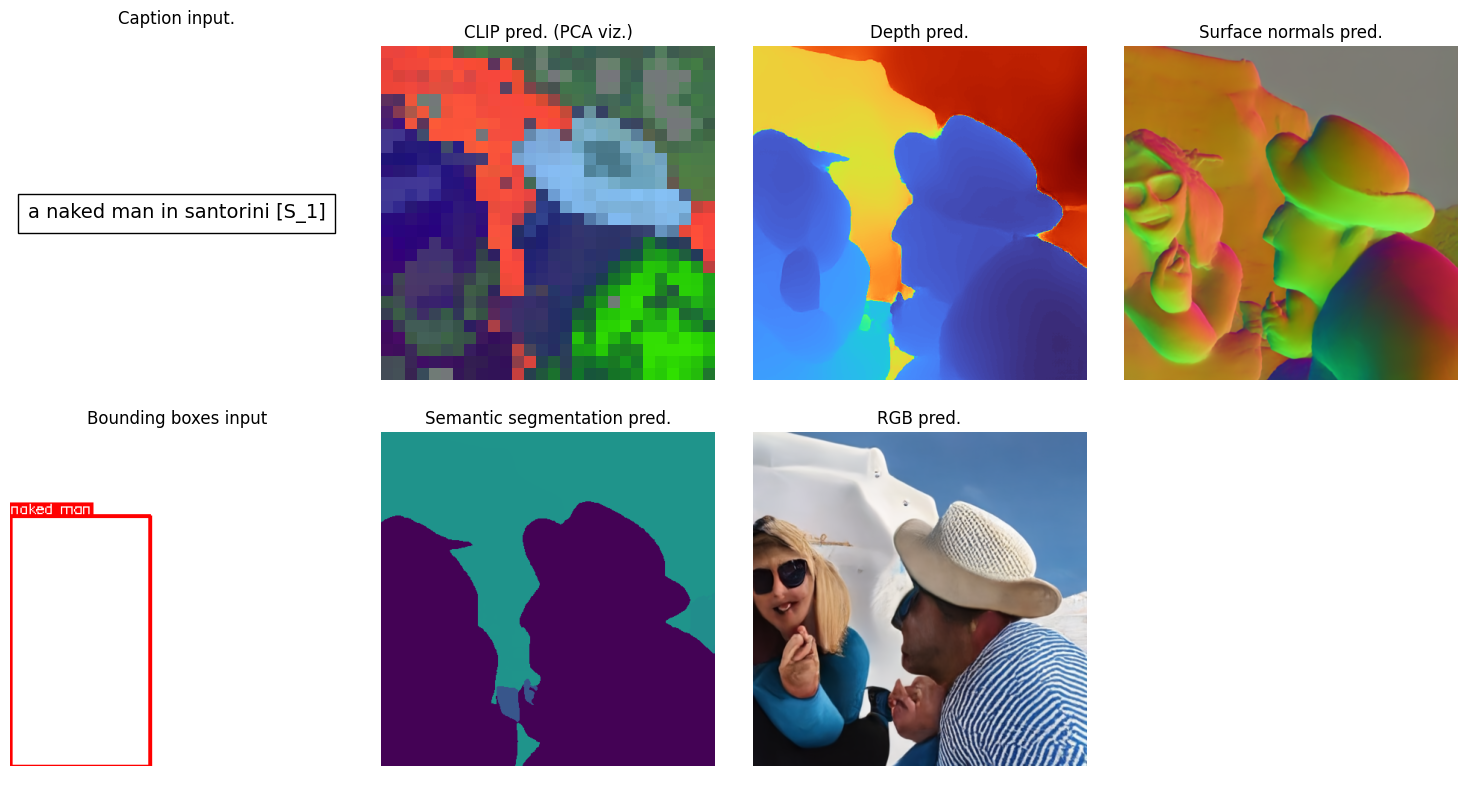

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,8), facecolor=(1, 1, 1))

plot_text_in_square(ax[0,0], caption, wrap_width=32)
ax[0,0].set_title('Caption input.')

ax[1,0].imshow(visualize_bboxes(None, dec_dict['det'][0].replace('[PAD] ', '')))
ax[1,0].set_title('Bounding boxes input')

ax[0,1].imshow(dec_dict_sr['tok_clip@448'])
ax[0,1].set_title('CLIP pred. (PCA viz.)')

ax[0,2].imshow(dec_dict_sr['tok_depth@448'])
ax[0,2].set_title('Depth pred.')

ax[0,3].imshow(dec_dict_sr['tok_normal@448'])
ax[0,3].set_title('Surface normals pred.')

ax[1,1].imshow(dec_dict_sr['tok_semseg@448'])
ax[1,1].set_title('Semantic segmentation pred.')

ax[1,2].imshow(dec_dict_sr['tok_rgb@448'])
ax[1,2].set_title('RGB pred.')

for axis in ax.flatten():
    axis.set_axis_off()

plt.tight_layout()
plt.show()